In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys
sys.path.append('../learnMSA')
from learnMSA import msa_hmm
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
train_filename = "data/homfam/train/egf.fasta"
out_filename = "results/egf_test.fasta"
num_models = 1
config = msa_hmm.config.make_default(num_models)
alignment = msa_hmm.align.run_learnMSA(train_filename, out_filename, config, verbose=False)

In [3]:
fasta_file = msa_hmm.fasta.Fasta(train_filename)
batch_gen = msa_hmm.train.DefaultBatchGenerator(fasta_file, alignment.num_models)
indices = tf.range(fasta_file.num_seq, dtype=tf.int64)
ds = msa_hmm.train.make_dataset(indices, batch_gen, batch_size=512, shuffle=False)
p = msa_hmm.align.get_state_posterior_probs(fasta_file,
                                batch_gen,
                                indices,
                                8000,
                                alignment.msa_hmm_layer,
                                alignment.encoder_model)
p

array([[4.3549457e-01, 9.7783130e-01, 9.8670423e-01, 9.8892081e-01,
        9.9165231e-01, 9.9501491e-01, 9.9682450e-01, 9.9742693e-01,
        9.9795473e-01, 9.0596169e-01, 9.9518418e-01, 9.9865043e-01,
        9.9937868e-01, 9.9936730e-01, 9.9946225e-01, 9.9966633e-01,
        9.9911416e-01, 9.9397522e-01, 9.9533051e-01, 9.9599010e-01,
        9.9932140e-01, 9.9976033e-01, 9.9978769e-01, 9.9979252e-01,
        9.9858481e-01, 9.9645174e-01, 9.9576002e-01, 9.9532872e-01,
        9.9506098e-01, 9.8891968e-01, 9.5585710e-01, 9.2210591e-01,
        1.4409413e-02, 3.1583797e-02, 6.9776624e-02, 1.9946231e-01,
        2.8357444e-02, 3.3112394e-07, 1.7167752e-14, 1.4451134e-03,
        1.6493606e-05, 2.4085487e-03, 4.2176846e-04, 4.8984818e-02,
        7.3018380e-02, 5.9826061e-02, 6.3324191e-02, 4.3576818e-02,
        9.7654521e-02, 1.2230632e-01, 4.7527417e-15, 1.3264418e-14,
        8.9211033e-13, 1.3894981e-12, 2.7846025e-05, 1.0224975e-02,
        6.8392215e-04, 2.1784417e-02, 4.3484291e

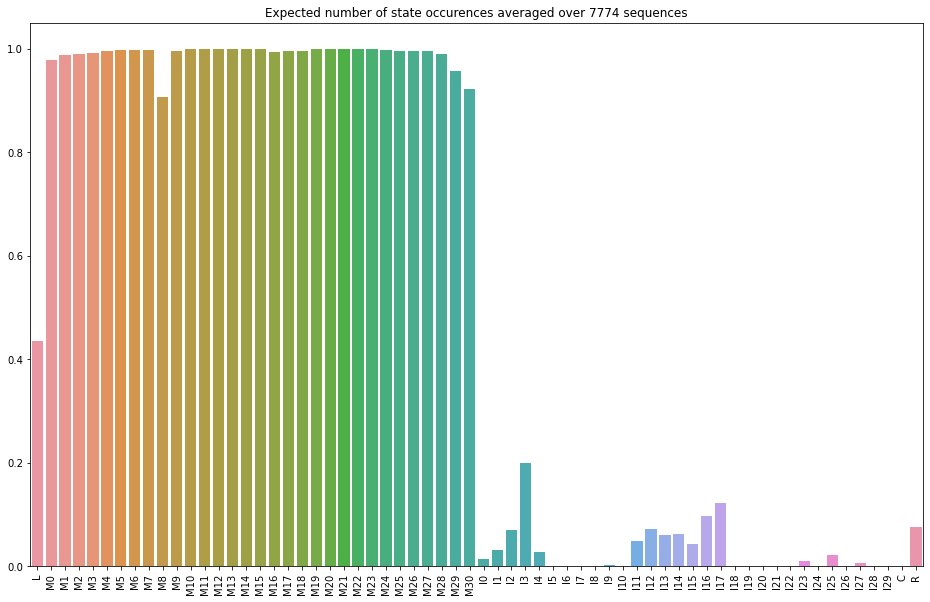

In [4]:
model_index = 0
no_terminal_state = True
f, ax = plt.subplots(1,1)
f.set_size_inches(16,10)
ax.set_title(f"Expected number of state occurences averaged over {indices.shape[0]} sequences")
num_matches = alignment.msa_hmm_layer.cell.length[model_index]
num_states = alignment.msa_hmm_layer.cell.num_states[model_index]
state_names = ["L"]+[f"M{i}" for i in range(num_matches)]+[f"I{i}" for i in range(num_matches-1)]+["C","R","T"]
sns.barplot(x=state_names[:num_states-no_terminal_state], y=p[model_index][:num_states-no_terminal_state], ax=ax)
plt.xticks(rotation=90);
plt.savefig("fig/expected_states.pdf", bbox_inches='tight')

In [5]:
for x,_ in ds:
    seqs = alignment.encoder_model(x)
    alpha = alignment.msa_hmm_layer.forward_recursion(seqs)
    beta = alignment.msa_hmm_layer.backward_recursion(seqs)
    tf.print("beta\n", beta)

beta
 [[[[-60.4695663 -53.720787 -58.7339935 ... -65.0803146 -105.519379 -127.119781]
   [-58.5724869 -57.3060913 -51.2119637 ... -63.2484703 -102.07399 -124.762924]
   [-57.3384514 -56.0416 -56.8007698 ... -62.0305862 -98.3329849 -122.981674]
   ...
   [-34.7050896 -14.2148638 -11.994216 ... -39.4206696 -1.14754558 0]
   [-34.7050896 -14.2148638 -11.994216 ... -39.4206696 -1.14754558 0]
   [-5.96046448e-08 1.19209282e-07 -5.96046448e-08 ... 1.19209282e-07 0 0]]

  [[-61.9161186 -55.1673164 -60.0163536 ... -66.525 -105.071648 -128.564667]
   [-60.0235825 -58.6973572 -52.6581879 ... -64.6917725 -101.626732 -126.220062]
   [-59.6135368 -58.3835106 -59.351532 ... -64.2035904 -98.612381 -125.357559]
   ...
   [-34.7050896 -14.2148638 -11.994216 ... -39.4206696 -1.14754558 0]
   [-34.7050896 -14.2148638 -11.994216 ... -39.4206696 -1.14754558 0]
   [-5.96046448e-08 1.19209282e-07 -5.96046448e-08 ... 1.19209282e-07 0 0]]

  [[-52.8084564 -46.0580368 -50.9681435 ... -57.4193077 -106.832069 -11